<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/DoWhy_example_on_Infant_Health_and_Development_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install dowhy

     |████████████████████████████████| 123 kB 5.4 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [3]:
# importing required libraries
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

In [4]:
data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data = data.astype({"treatment":'bool'}, copy=False)
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,0,1,1,2,0,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0


# Step 1. Causal Model specification

In [5]:
# Create a causal model from the data and given common causes.
xs = ""
for i in range(1,26):
    xs += ("x"+str(i)+"+")

model=CausalModel(
        data = data,
        treatment='treatment',
        outcome='y_factual',
        common_causes=xs.split('+')
        )

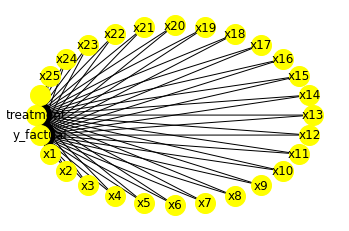

In [6]:
model.view_model()

# Step 2.Identify

In [7]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(y_factual|x19,x17,x2,x20,x25,x13,x15,x11,x23,x8,x24,x
d[treatment]                                                                  

                                                 
5,x9,x16,x21,x12,x22,x7,x18,x14,x1,x3,x4,x10,x6))
                                                 
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x19,x17,x2,x20,x25,x13,x15,x11,x23,x8,x24,x5,x9,x16,x21,x12,x22,x7,x18,x14,x1,x3,x4,x10,x6,U) = P(y_factual|treatment,x19,x17,x2,x20,x25,x13,x15,x11,x23,x8,x24,x5,x9,x16,x21,x12,x22,x7,x18,x14,x1,x3,x4,x10,x6)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



# Step 3.Estimate

In [8]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = data[data["treatment"]==1]
data_0 = data[data["treatment"]==0]

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(y_factual|x19,x17,x2,x20,x25,x13,x15,x11,x23,x8,x24,x
d[treatment]                                                                  

                                                 
5,x9,x16,x21,x12,x22,x7,x18,x14,x1,x3,x4,x10,x6))
                                                 
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x19,x17,x2,x20,x25,x13,x15,x11,x23,x8,x24,x5,x9,x16,x21,x12,x22,x7,x18,x14,x1,x3,x4,x10,x6,U) = P(y_factual|treatment,x19,x17,x2,x20,x25,x13,x15,x11,x23,x8,x24,x5,x9,x16,x21,x12,x22,x7,x18,x14,x1,x3,x4,x10,x6)

## Realized estimand
b: y_factual~treatment+x19+x17+x2+x20+x25+x13+x15+x11+x23+x8+x24+x5+x9+x16+x21+x12+x22+x7+x18+x14+x1+x3+x4+x10+x6
Target units: ate

##

In [9]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Causal Estimate is 3.9791388232170393
ATE 4.021121012430832


In [10]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification", method_params={'num_strata':50, 'clipping_threshold':5}
)

print("Causal Estimate is " + str(estimate.value))
print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Causal Estimate is 3.4550471588628207
ATE 4.021121012430832


In [11]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


Causal Estimate is 3.409737824413048
ATE 4.021121012430832


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 4. Refute

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)


Refute: Add a Random Common Cause
Estimated effect:3.409737824413048
New effect:3.4188412903408447



In [17]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:3.409737824413048
New effect:-0.010143156735866939
p value:0.48



In [18]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:3.409737824413048
New effect:3.3750110937144586
p value:0.35



# Interpretation

We get:

Causal Estimate is: 3.9791388232170393

ATE: 4.021121012430832

For this example we have the true effect of treatment on the outcome

In [35]:
data[['treatment','y_factual','y_cfactual']].sample(10)


,treatment,y_factual,y_cfactual
722,False,3.778649,6.770402
688,True,7.342641,1.713163
236,False,1.570458,6.437022
154,False,3.546917,6.554049
348,False,2.485087,6.659411
328,False,1.893695,6.812002
478,False,3.182114,5.342471
550,False,0.677101,7.061750
491,False,1.944537,6.185291
480,False,1.797997,5.957574


In [31]:
data['factualLessCouterFactual']=data.y_factual-data.y_cfactual

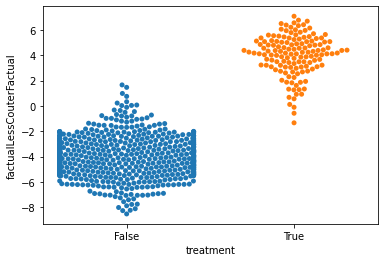

In [36]:
ax = sns.swarmplot(data=data[['treatment','factualLessCouterFactual']], x="treatment", y="factualLessCouterFactual")